Author: Mike Stanley <br>
Created: 9/10/2018

Demo of hierarchical bayesian techniques used in flow cytometry data analysis for DSE team at tellic on 9/11/2018.

# Distilled Problem Statement

Given J samples containing N events, we find K clusters to group the data. For our synthetic data, we only consider 1-dimensional data since I’m still working on how to implement DPGMMs in pymc3 with multi-dimensional data…

In [220]:
import pandas as pd
import numpy as np
import pickle
from scipy import stats
import pymc3 as pm
from theano import tensor as T
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Generate Data

In [5]:
# data generating parameters
NUM_SAMPLES = 10
NUM_CLUST = 3
NUM_CELLS = 1000

In [45]:
data_gen_props = {
    'distributions':{
        0:stats.norm(loc=-3, scale=1),
        1:stats.norm(loc=1, scale=1),
        2:stats.norm(loc=7, scale=3),
    },
    'mix_prop':{
        'dir_sample':stats.dirichlet(alpha=[10, 5, 15])
    }
}

In [223]:
stats.dirichlet(alpha=[10, 5, 15]).rvs(size=10)

array([[0.32214182, 0.0627079 , 0.61515028],
       [0.48258495, 0.14637201, 0.37104304],
       [0.28424313, 0.30841467, 0.4073422 ],
       [0.16100943, 0.24586603, 0.59312455],
       [0.22837072, 0.16986646, 0.60176282],
       [0.26907394, 0.1747765 , 0.55614955],
       [0.20843348, 0.064419  , 0.72714752],
       [0.41024393, 0.18657241, 0.40318366],
       [0.54667761, 0.13274763, 0.32057476],
       [0.42818056, 0.10413895, 0.46768049]])

In [46]:
def draw_cell_sample(N=NUM_CELLS, data_gen_dict=data_gen_props):
    '''
    Draws one sample of cell data, returned as np array
    Takes as input N for the number of cells to generate
    in the sample, and a dictionary object like the above
    '''
    # make a place to store the data
    cell_sample = np.zeros(N)
    
    # get the mixing proportions
    mix_props = data_gen_dict['mix_prop']['dir_sample'].rvs()[0]
    
    # decide the cluster each cell will come from
    cluster_origin = np.random.choice(np.arange(len(mix_props)), p=mix_props, size=N)
    
    for idx, z_i in enumerate(cluster_origin):
        cell_sample[idx] = data_gen_dict['distributions'][z_i].rvs()
    
    return cell_sample

In [47]:
# draw one sample for each of our predefined number of samples
samples = {}

for i in range(NUM_SAMPLES):
    samples['sample_'+str(i)] = draw_cell_sample()

##### Visualize 2 samples

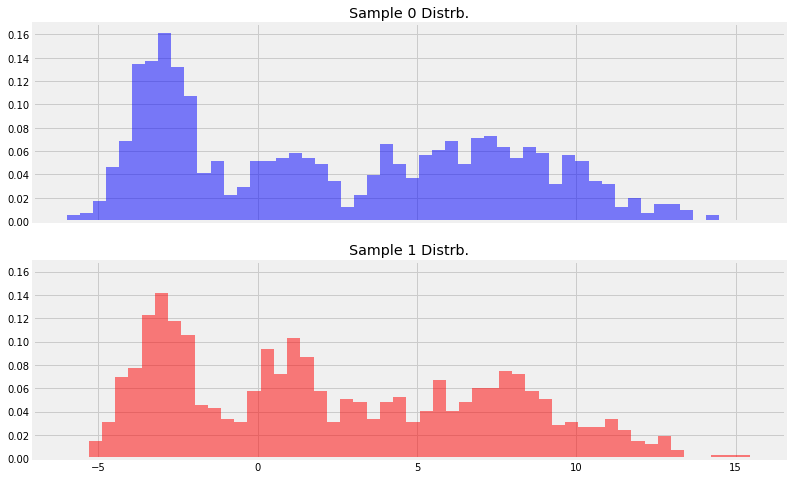

In [69]:
# samples
sample0 = samples['sample_0']
sample1 = samples['sample_1']

# plot
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12, 8))

# sample 0
ax[0].hist(sample0, bins=50, color='blue', alpha=0.5, density=True)
ax[0].set_title('Sample 0 Distrb.')

# sample 1
ax[1].hist(sample1, bins=50, color='red', alpha=0.5, density=True)
ax[1].set_title('Sample 1 Distrb.')

plt.show()

##### Export the data

In [222]:
with open('/Users/mikestanley/Data/Simulated_Data/flow_cyt_k3_09112018.pk', 'wb') as handle:
    pickle.dump(samples, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Fit a DPGMM to one of the samples

We use `sample0` from above

In [49]:
# define the max number of mixing components
K = 30

In [74]:
def stick_breaking(beta):
    '''
    Sethuraman Stick Breaking Process
    '''
    portion_remaining = T.concatenate([[1], T.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [75]:
with pm.Model() as model_sample0:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1, alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
    component = pm.Categorical('component', w, shape=NUM_CELLS)
    
    gamma = pm.InverseGamma('inv_gamma', 1., 1., shape=K)
    mu = pm.Normal('mu', 0., 20., shape=K)
    obs = pm.Normal('obs', mu[component], gamma[component],
                    observed=sample0)

In [76]:
with model_sample0:
    step1 = pm.Metropolis(vars=[alpha, beta, w, gamma, mu, obs])
    step2 = pm.ElemwiseCategorical([component], np.arange(K))
    
    trace_ = pm.sample(10000, [step1, step2])
    
trace = trace_[5000::5]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [mu]
>>Metropolis: [inv_gamma]
>>Metropolis: [beta]
>>Metropolis: [alpha]
>ElemwiseCategorical: [component]
Sampling 2 chains: 100%|██████████| 21000/21000 [04:00<00:00, 87.16draws/s] 
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


##### Visualizing output

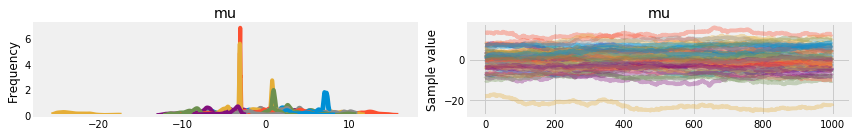

In [55]:
# visualize trace of cluster means
pm.traceplot(trace, varnames=['mu'])
plt.show()

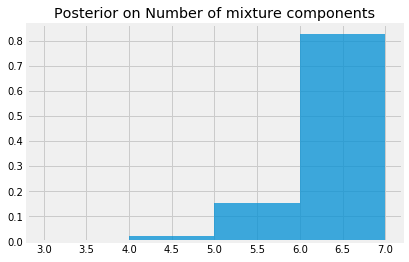

In [56]:
# how many components did we use?
n_components = np.apply_along_axis(lambda x: np.unique(x).size, 1, trace['component'])

bins = np.arange(n_components.min(), n_components.max() + 1)
plt.hist(n_components+1, bins=bins, density=True, alpha=0.75)
plt.title('Posterior on Number of mixture components')
plt.show()

In [57]:
# posterior estimate of our distribution as a sum of mixture components

# values to plot on xaxis
x_plot = np.linspace(sample0.min(), sample0.max(), num=200)

# compute our posterior estimates
post_pdf_contribs = stats.norm.pdf(np.atleast_3d(x_plot),
                                   trace['mu'][:,np.newaxis,:],
                                   trace['inv_gamma'][:, np.newaxis, :])

post_pdf = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1) # sum over components
post_pdf_low, post_pdf_high = np.percentile(post_pdf, [2.5, 97.5], axis=0)

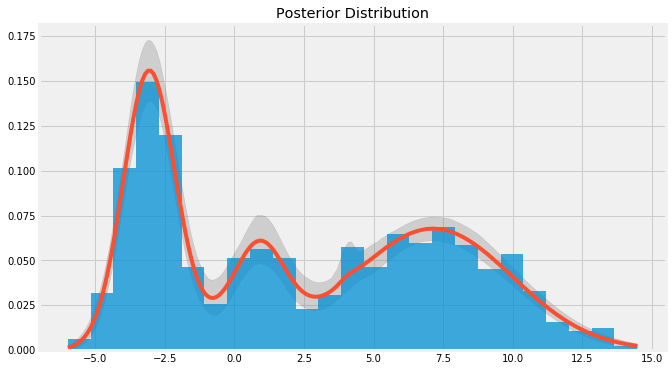

In [61]:
# plot the above
plt.figure(figsize=(10, 6))

plt.hist(sample0, bins=25, density=True, alpha=0.75)

plt.plot(x_plot, post_pdf.mean(axis=0))
plt.fill_between(x_plot, post_pdf_low, post_pdf_high, color='gray', alpha=0.3)

plt.title('Posterior Distribution')
plt.show()

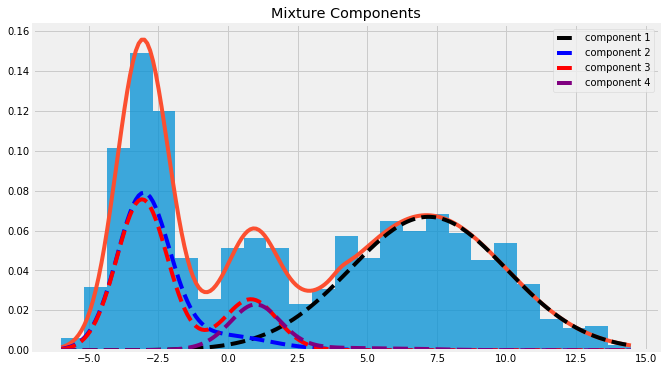

In [60]:
# plot some of the mixture components
# now plot with components
plt.figure(figsize=(10, 6))

plt.hist(sample0, bins=25, density=True, alpha=0.75)

plt.plot(x_plot, post_pdf.mean(axis=0))

# components
component_pdfs = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0)

plt.plot(x_plot, component_pdfs[:, 0], label='component 1', 
         linestyle='--', color='k')
plt.plot(x_plot, component_pdfs[:, 1], label='component 2', 
         linestyle='--', color='blue')
plt.plot(x_plot, component_pdfs[:, 2], label='component 3', 
         linestyle='--', color='red')
plt.plot(x_plot, component_pdfs[:, 3], label='component 4', 
         linestyle='--', color='purple')

plt.title('Mixture Components')
plt.legend(loc='best')
plt.show()

In [66]:
# what does the posterior look like if we just keep the first 7 distributions?

# compute our posterior estimates
post_pdf_contribs_7 = stats.norm.pdf(np.atleast_3d(x_plot),
                                     trace['mu'][:,np.newaxis,:7],
                                     trace['inv_gamma'][:, np.newaxis, :7])

post_pdf_7 = (trace['w'][:, np.newaxis, :7] * post_pdf_contribs_7).sum(axis=-1) # mean of all components
post_pdf_low_7, post_pdf_high_7 = np.percentile(post_pdf_7, [2.5, 97.5], axis=0)

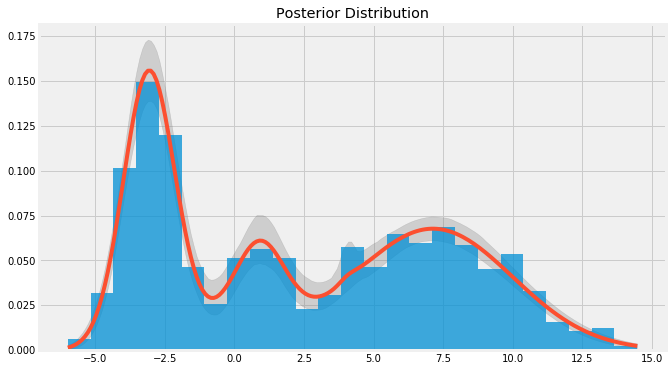

In [67]:
# plot the above
plt.figure(figsize=(10, 6))

plt.hist(sample0, bins=25, density=True, alpha=0.75)

plt.plot(x_plot, post_pdf_7.mean(axis=0))
plt.fill_between(x_plot, post_pdf_low_7, post_pdf_high_7, color='gray', alpha=0.3)

plt.title('Posterior Distribution')
plt.show()

# HDPGMM over 2 samples

In [130]:
# restate K; max number of components
K = 30

In [208]:
with pm.Model() as model_sample01:
    # find hierarchical stick breaking weights
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w_b = pm.Deterministic('w_b', stick_breaking(beta))
    one_min_beta_K = pm.Deterministic('beta_K', T.sum(beta))
    
    # sample 0
    pi0 = pm.Beta('pi0', alpha * beta, alpha * one_min_beta_K, shape=K)
    w_pi0 = pm.Deterministic('w_pi0', stick_breaking(pi0))
    component0 = pm.Categorical('component0', w_pi0, shape=NUM_CELLS)
    
    inv_gamma0 = pm.InverseGamma('inv_gamma0', 1., 1., shape=K)
    mu0 = pm.Normal('mu0', 0., 20., shape=K)
    
    obs0 = pm.Normal('obs0', mu0[component0], inv_gamma0[component0], 
                     observed=sample0)
    
    # sample 1
    pi1 = pm.Beta('pi1', alpha * beta, alpha * one_min_beta_K, shape=K)
    w_pi1 = pm.Deterministic('w_pi1', stick_breaking(pi1))
    component1 = pm.Categorical('component1', w_pi1, shape=NUM_CELLS)
    
    inv_gamma1 = pm.InverseGamma('inv_gamma1', 1., 1., shape=K)
    mu1 = pm.Normal('mu1', 0., 20., shape=K)
    obs1 = pm.Normal('obs1', mu1[component1], inv_gamma1[component1], 
                     observed=sample1)

In [209]:
with model_sample01:
    step1 = pm.Metropolis([alpha, beta, w_b, 
                           pi0, w_pi0, inv_gamma0, mu0, obs0,
                           pi1, w_pi1, inv_gamma1, mu1, obs1])
    step2 = pm.ElemwiseCategorical([component0], np.arange(K))
    step3 = pm.ElemwiseCategorical([component1], np.arange(K))
    
    trace_ = pm.sample(draws=10000, step=[step1, step2, step3])
    
trace = trace_[5000::5]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [mu1]
>>Metropolis: [inv_gamma1]
>>Metropolis: [pi1]
>>Metropolis: [mu0]
>>Metropolis: [inv_gamma0]
>>Metropolis: [pi0]
>>Metropolis: [beta]
>>Metropolis: [alpha]
>ElemwiseCategorical: [component0]
>ElemwiseCategorical: [component1]
Sampling 2 chains: 100%|██████████| 21000/21000 [07:52<00:00, 44.42draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


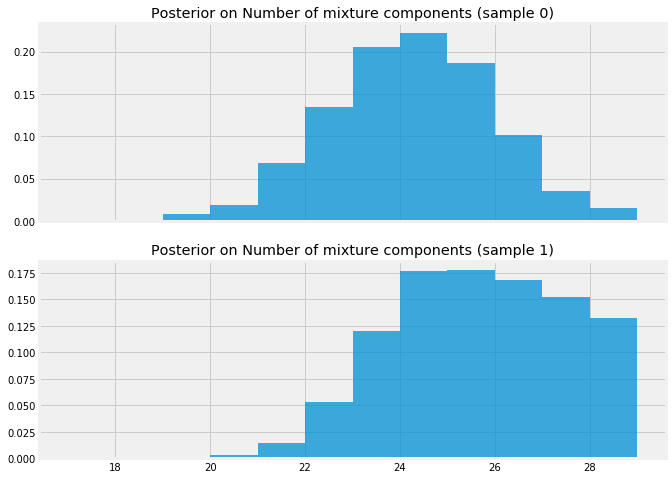

In [211]:
# find the posterior for the number of components in each sample

n_components0 = np.apply_along_axis(lambda x: np.unique(x).size, 1, trace['component0'])
n_components1 = np.apply_along_axis(lambda x: np.unique(x).size, 1, trace['component1'])

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# sample 0
bins0 = np.arange(n_components0.min(), n_components0.max() + 1)
ax[0].hist(n_components0+1, bins=bins0, density=True, alpha=0.75)
ax[0].set_title('Posterior on Number of mixture components (sample 0)')

# sample 1
bins1 = np.arange(n_components1.min(), n_components1.max() + 1)
ax[1].hist(n_components1+1, bins=bins1, density=True, alpha=0.75)
ax[1].set_title('Posterior on Number of mixture components (sample 1)')

plt.show()

### How do the learned distributions fit the data?

In [214]:
# posterior estimate of our distribution as a sum of mixture components

# values to plot on xaxis
x_plot0 = np.linspace(sample0.min(), sample0.max(), num=200)
x_plot1 = np.linspace(sample1.min(), sample1.max(), num=200)

## sample 0

# compute our posterior estimates
post_pdf_contribs0 = stats.norm.pdf(np.atleast_3d(x_plot0),
                                    trace['mu0'][:,np.newaxis,:],
                                    trace['inv_gamma0'][:, np.newaxis, :])

post_pdf0 = (trace['w_pi0'][:, np.newaxis, :] * post_pdf_contribs0).sum(axis=-1) # sum over components
post_pdf_low0, post_pdf_high0 = np.percentile(post_pdf0, [2.5, 97.5], axis=0)

## sample 1

# compute our posterior estimates
post_pdf_contribs1 = stats.norm.pdf(np.atleast_3d(x_plot1),
                                    trace['mu1'][:,np.newaxis,:],
                                    trace['inv_gamma1'][:, np.newaxis, :])

post_pdf1 = (trace['w_pi1'][:, np.newaxis, :] * post_pdf_contribs1).sum(axis=-1) # sum over components
post_pdf_low1, post_pdf_high1 = np.percentile(post_pdf1, [2.5, 97.5], axis=0)

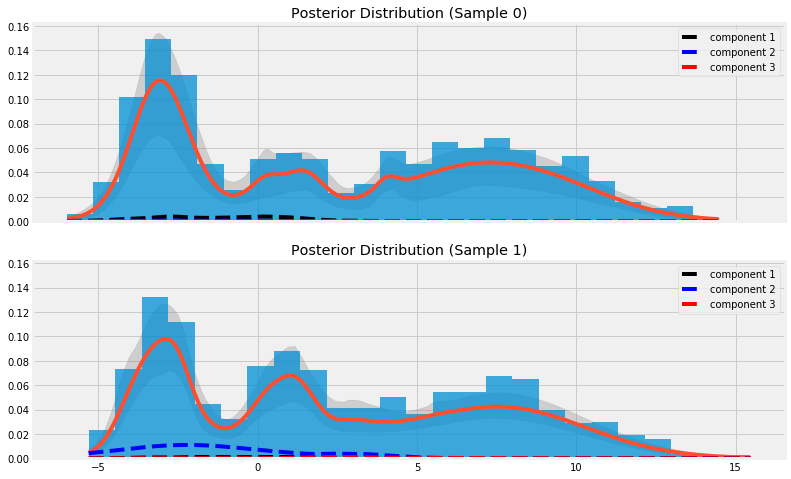

In [218]:
# plot the above
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12, 8))

# sample 0
ax[0].hist(sample0, bins=25, density=True, alpha=0.75)
ax[0].plot(x_plot0, post_pdf0.mean(axis=0))
ax[0].fill_between(x_plot0, post_pdf_low0, post_pdf_high0, color='gray', alpha=0.3)
ax[0].set_title('Posterior Distribution (Sample 0)')

# plot a few of the mixture components for sample 0
component0_pdfs = (trace['w_pi0'][:, np.newaxis, :] * post_pdf_contribs0).mean(axis=0)

ax[0].plot(x_plot0, component0_pdfs[:, 0], label='component 1', 
           linestyle='--', color='k')
ax[0].plot(x_plot0, component0_pdfs[:, 1], label='component 2', 
           linestyle='--', color='blue')
ax[0].plot(x_plot0, component0_pdfs[:, 2], label='component 3', 
           linestyle='--', color='red')
ax[0].legend(loc='best')

# sample 1
ax[1].hist(sample1, bins=25, density=True, alpha=0.75)
ax[1].plot(x_plot1, post_pdf1.mean(axis=0))
ax[1].fill_between(x_plot1, post_pdf_low1, post_pdf_high1, color='gray', alpha=0.3)
ax[1].set_title('Posterior Distribution (Sample 1)')

# plot a few of the mixture components for sample 1
component1_pdfs = (trace['w_pi1'][:, np.newaxis, :] * post_pdf_contribs0).mean(axis=0)

ax[1].plot(x_plot1, component1_pdfs[:, 0], label='component 1', 
           linestyle='--', color='k')
ax[1].plot(x_plot1, component1_pdfs[:, 1], label='component 2', 
           linestyle='--', color='blue')
ax[1].plot(x_plot1, component1_pdfs[:, 2], label='component 3', 
           linestyle='--', color='red')
ax[1].legend(loc='best')

plt.show()

# Open Questions

1. How can the above process be extended to an arbitrary number of samples?
2. Although we get a posterior distribution for the number of clusters, we still don't really get a definitive answer to how many clusters there should be. In fact, in this case, we would dramatically overestimate the number of clusters since we really just started with 3.
3. Not entirely sure how the above process (assuming I've justifiably represented the HDP structure) alleviates the cluster linking problem.
4. still not sure how to attach meaning to the clusters even if they are linked across samples. 
5. in the context of fcm, how can we be sure that the clusters that arise from the HDP are real biological clusters?